In [485]:
import argparse

import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict
import cv2
import glob
import json
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt
from operator import concat
import os
import pandas as pd
import pickle
from PIL import Image, ImageFilter
#from pycocotools.coco import COCO
import pydot
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import check_random_state
import shutil
import tensorflow as tf
from time import time
import traceback
import timeit
import urllib.request
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from random import shuffle
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools

In [3]:
print(azureml.core.VERSION)
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="9bce0414-e6b9-4c79-b146-74018a4b09ac")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_classification")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="3e9a2408-19d1-4ca2-bb63-339d47d3baaa")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_back-up")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except Exception as e:
    print(e)
    print("Workspace not accessible. Change your parameters or create a new workspace below")
    
cpu_cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

gpu_cluster_name = "gpucluster"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print("Found existing gpu cluster")
except ComputeTargetException:
    print("Creating new gpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                           min_nodes=0,
                                                           max_nodes=4)
    # Create the cluster with the specified name and configuration
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    gpu_cluster.wait_for_completion(show_output=True)


1.0.17
Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json
Workspace configuration succeeded. Skip the workspace creation steps below
Found existing cpucluster
Found existing gpu cluster


In [4]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json


In [5]:
experiment_name = 'multi-class_classification'
exp = Experiment(workspace=ws, name=experiment_name)

In [6]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "gpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_NC6") #"STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. gpucluster


In [7]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
#ds.upload(src_dir='./data', target_path='data', overwrite=False, show_progress=True)

AzureBlob multilabelback2880750212 azureml-blobstore-944dae39-f956-45b0-b88a-38ce6482276b


In [8]:
script_folder = './coco-multi-label'
os.makedirs(script_folder, exist_ok=True)

In [9]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)

with open("data/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)
'''
with open("data/annotations/instances_train2014.json") as read_file:
    instances = json.load(read_file)
with open("data/annotations/person_keypoints_train2014.json") as read_file:
    keypoints = json.load(read_file)
'''

'\nwith open("data/annotations/instances_train2014.json") as read_file:\n    instances = json.load(read_file)\nwith open("data/annotations/person_keypoints_train2014.json") as read_file:\n    keypoints = json.load(read_file)\n'

NameError: name 'COCO' is not defined

Number of images in 2014 train: 82783
Number of annotations in 2014 train: 604907
Number of annotations/image in 2014 train: 7.307140354903785
82081
Label density in 2014 train: 0.0913392544362973
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball glove: 2689
41skateboard: 4012
42surfboard: 4161
43tennis racket: 3411
44bottle: 16983
46wine glass: 5618
47cup: 14513
48fork: 3918
49knife: 5536
50spoon: 4287
51bowl: 10064
52banan

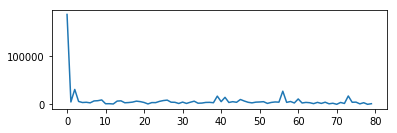


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [10]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
val_images = val["images"]
#val_images = val["images"]
print("Number of images in 2014 train: "+str(len(train_images)))
#print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
train_annotations = train["annotations"]
val_annotations = val["annotations"]
#print(train_annotations[1:20])
#val_annotations = val["annotations"]
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
#print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
#print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")
train_categories = np.zeros(100, dtype=object)
#val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
#for annotation in val_annotations:
#    val_categories[annotation['category_id']] += 1
train_categories = train_categories[train_categories != 0]
#val_categories = val_categories[val_categories != 0]
print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
#print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
#for i in range(0, len(val_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
#    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
#plt.subplot(212)
#plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
#val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [ ]:
import sys
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [194]:
image_id = 274467 #9,25,30,34,36,49
def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items
items = findAnnotations(image_id, 'image_id')
for item in items:
    print(item["category_id"])

1
22
1
1
1
1
1
1
1


In [ ]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)

colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []fig,ax = plt.subplots(1)
ax.imshow(image)
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [493]:
import argparse

import azureml.core
from azureml.core import Run
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (48, 48),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    sift_features = []
    lbp_features = []
    haar_features = []
    i = 0;
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        #int_img = integral_image(img)
        #lbp_features.append(multiblock_lbp(int_img, 0, 0, 3, 3))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 48, 48, 'type-3-x'))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return hog_features, daisy_features, lbp_features, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = OneVsRestClassifier(LinearSVC())
    #clf = OneVsRestClassifier(SVC(kernel='poly'))
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    model = Sequential()

    model.add(Conv2D(layer_size, (kernel_size, kernel_size), input_shape=x_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    
    return IoU

def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image
 
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def slidingWindow(img):
    image = cv2.imread('data/' + path + img +'.jpg')
    (winW, winH) = (48, 48)
    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            box = preProcessImage(window)
            features = calculateFeatures([box])
            prediction = svmHOG.predict(features[0])
            print(prediction)
            clone = resized.copy()
            #fig,ax = plt.subplots(1)
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(1)
            
def probability_mass_split(y, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
    print("Fold distributions are")
    print(fold_dist)
    return index_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

data_folder = 'data'

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

In [38]:
#def IterativeStratification(labels, r, random_state):
num_splits = 5
r = np.asarray([1 / num_splits] * num_splits)
random_state = check_random_state(42)

n_samples = labels.shape[0]
test_folds = np.zeros(n_samples, dtype=int)

# Calculate the desired number of examples at each subset
c_folds = r * n_samples

# Calculate the desired number of examples of each label at each subset
c_folds_labels = np.outer(r, labels.sum(axis=0))

labels_not_processed_mask = np.ones(n_samples, dtype=bool)

while np.any(labels_not_processed_mask):
    # Find the label with the fewest (but at least one) remaining examples,
    # breaking ties randomly
    num_labels = labels[labels_not_processed_mask].sum(axis=0)
    num_labels = np.asarray(num_labels)
    print(type(num_labels))
    print(num_labels)
    print(num_labels.sum())
    # Handle case where only all-zero labels are left by distributing
    # across all folds as evenly as possible (not in original algorithm but
    # mentioned in the text). (By handling this case separately, some
    # code redundancy is introduced; however, this approach allows for
    # decreased execution time when there are a relatively large number
    # of all-zero labels.)
    if num_labels.sum() == 0:
        sample_idxs = np.where(labels_not_processed_mask)[0]

        for sample_idx in sample_idxs:
            fold_idx = np.where(c_folds == c_folds.max())[0]

            if fold_idx.shape[0] > 1:
                fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

            test_folds[sample_idx] = fold_idx
            c_folds[fold_idx] -= 1

        break

    label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
    if label_idx.shape[0] > 1:
        label_idx = label_idx[random_state.choice(label_idx.shape[0])]

    sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]

    for sample_idx in sample_idxs:
        # Find the subset(s) with the largest number of desired examples
        # for this label, breaking ties by considering the largest number
        # of desired examples, breaking further ties randomly
        label_folds = c_folds_labels[:, label_idx]
        fold_idx = np.where(label_folds == label_folds.max())[0]

        if fold_idx.shape[0] > 1:
            temp_fold_idx = np.where(c_folds[fold_idx] ==
                                     c_folds[fold_idx].max())[0]
            fold_idx = fold_idx[temp_fold_idx]

            if temp_fold_idx.shape[0] > 1:
                fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]

        test_folds[sample_idx] = fold_idx
        labels_not_processed_mask[sample_idx] = False

        # Update desired number of examples
        c_folds_labels[fold_idx, labels[sample_idx]] -= 1
        c_folds[fold_idx] -= 1

    #return test_folds

#test_folds = IterativeStratification(labels=labelcollection, r=r, random_state=rng)

<class 'numpy.ndarray'>
[58  1  1 ... 85 85 85]
17777584


IndexError: too many indices for array

In [13]:

'''
#testsplits = list(chunks(dummy_annotations, 50))
#labels, features = splitPreprocessing(testsplits, data_folder, path)

'''

categories_subset = [2,52]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))




c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [289]:
def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    try:
        image_id_string = str(image_id).zfill(12)
        image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
        image = preProcessImage(image) 
        annotations = findAnnotations(image_id, 'image_id', train_annotations)
    except Exception as ex:
        print(ex) 
    for annotation in annotations:
        image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                               , (48, 48),
                       anti_aliasing=True)
        bounded_images.append(image_resized)
        bounded_annotations.append(annotation['category_id'])       
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


In [417]:
print(images_train[1])

[[[0.21611752 0.24495533 0.1768004  ... 0.28481874 0.27704343 0.26100857]
  [0.12721626 0.1720974  0.23902519 ... 0.32188185 0.30939419 0.28408601]
  [0.17066671 0.3717747  0.52956141 ... 0.32784024 0.30857758 0.28009265]
  ...
  [0.3516521  0.38121848 0.3675508  ... 0.48588133 0.46274353 0.40846142]
  [0.3254989  0.35692239 0.3494512  ... 0.52299184 0.48897578 0.4534547 ]
  [0.30203444 0.33799629 0.34615439 ... 0.51888274 0.48679799 0.45085364]]

 [[0.21650074 0.21538569 0.22596114 ... 0.34805116 0.34928583 0.36014425]
  [0.24423325 0.26059546 0.26982914 ... 0.30752242 0.28846537 0.25003961]
  [0.21626577 0.30279821 0.29958791 ... 0.28180021 0.28990967 0.23855456]
  ...
  [0.52637388 0.60627405 0.6441457  ... 0.42914326 0.42291356 0.4010718 ]
  [0.2133712  0.2980555  0.47322508 ... 0.39807434 0.34338351 0.317083  ]
  [0.18562443 0.19182221 0.19241334 ... 0.32676138 0.33427617 0.20846716]]

 [[0.29357627 0.33657758 0.34259509 ... 0.53213467 0.53302364 0.49054245]
  [0.24188371 0.321774

In [ ]:
labels = np.asarray(list(itemsets.values()))
keys = np.asarray(list(itemsets.keys()))
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)

rand_sets,rand_images = random_sets(labels,keys,20)


In [510]:
random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

191188
Buffer and memoryview are not contiguous in the same dimension.
259687
zero-size array to reduction operation minimum which has no identity


In [511]:
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))


In [ ]:
#bounded_annotations_train = [ x for x in bounded_annotations_train if not (x==i).all()]
#bounded_annotations_val = [ x for x in bounded_annotations_val if not (x==i).all()]
#images_train = [ x for x in images_train if not (x==[]).all()]
#images_val = [ x for x in images_val if not (x==[]).all()]
'''
for idx,image in enumerate(images_train):
    if image == []:
        images_train.remove(idx)
for idx,image in enumerate(images_val):
    if image == []:
        images_val.remove(idx)
'''
images_train = images_train[~np.all(images_train == [], axis=0)]
images_val = images_val[~np.all(images_val == [], axis=0)]

3


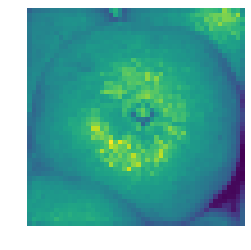

In [471]:
print(images_train[1].ndim)
fig, ax = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(images_train[1][3])

In [ ]:
images_train = np.vstack(images_train)
images_val = np.vstack(images_val)


In [495]:
print(full_picture_features[1][0])

[0.000562092885731698, 0.0003632850842555536, 0.0004523573282869526, 0.0025676115394862057, 0.01305433815893622, 0.02169680177804156, 0.009080055055382884, 0.001741334965500611, 0.0053496594714928635, 0.008538572340773914, 0.004611494866589803, 0.003942823609376975, 0.017385605088586706, 0.03340426883613727, 0.016421583113518257, 0.0041220150269409206, 0.004641485360624839, 0.004735706447599752, 0.002116213261856625, 0.00522420414758149, 0.02176052320586591, 0.029126971588919765, 0.010753792806933693, 0.0032599990794713366, 0.0005684849329525348, 0.0003896166698959264, 0.00066558692044777, 0.003994887963503625, 0.015877171541517927, 0.0201310749158181, 0.007128053292510018, 0.0014290401062124322, 0.0006753055736931638, 0.0007315791593936333, 0.00045667352878351757, 0.0014321868179498845, 0.0072647057724548325, 0.012696154635452712, 0.005640184288927874, 0.001239961010571742, 0.0004936302851982971, 0.0005216827053731105, 0.0003947449228740883, 0.0013071284374788312, 0.00695338769726632,

In [ ]:


clf = LinearSVC()
ovr = OneVsRestClassifier(clf)
full_picture_features = calculateFeatures(images_train) 
full_picture_features_val = calculateFeatures(images_val) 
picture_features = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]
svm = svmFit(picture_features, bounded_annotations_train)
svmResults = svmPredict(picture_features_val, bounded_annotations_val, svm)

#features_concat = [np.concatenate((x,y,z)) for x,y,z in zip(full_picture_features[0], full_picture_features[1], full_picture_features[2])]
#features_val_concat = [np.concatenate((x,y,z)) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]
ovr.fit(full_picture_features[0], bounded_annotations_train)
Y_pred_ovr = ovr.score(full_picture_features_val[0], bounded_annotations_val)
print(Y_pred_ovr)
Y_pred_ovr = ovr.predict(full_picture_features_val[0])
ovr_jaccard_score = jaccard_similarity_score(bounded_annotations_val, Y_pred_ovr)

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(clf, random_state=i)
          for i in range(90)]
for chain in chains:
    chain.fit(full_picture_features[0], bounded_annotations_train)

Y_pred_chains = np.array([chain.predict(features_val_concat[0]) for chain in
                          chains])

In [14]:
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)

'''
x_trainfeat, x_testfeat, y_trainfeat, y_testfeat = train_test_split(
    features, y_train, stratify=y_train,  test_size=0.25, random_state=42)
'''

'\nx_trainfeat, x_testfeat, y_trainfeat, y_testfeat = train_test_split(\n    features, y_train, stratify=y_train,  test_size=0.25, random_state=42)\n'

In [ ]:
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]

In [20]:
#svm = svmFit(features_concat, y_train)
#svmResults = svmPredict(features_val_concat, y_test, svm)


svmHOG = svmFit(features[0], y_train)
svmHOGResults = svmPredict(features_val[0], y_test, svmHOG)
#saveModel(svm, 'SVM_DAISY.sav')
#os.makedirs('outputs', exist_ok=True)


Fitting the classifier to train
Predicting the test set
              precision    recall  f1-score   support

           2       0.73      0.76      0.74      2474
          52       0.79      0.77      0.78      2925

   micro avg       0.76      0.76      0.76      5399
   macro avg       0.76      0.76      0.76      5399
weighted avg       0.76      0.76      0.76      5399

[[1870  604]
 [ 684 2241]]


In [ ]:
slidingWindow("000000002664")

In [153]:
rfHOG = randomForestFit(features_concat, y_train, 1000)
rfHOG_results = rfPredict(features_val_concat, y_test, rfHOG)



Fitting the classifier to train
Completed in 161.189s
Predicting the test set
Completed in 4.056s
Accuracy: 0.6923076923076923


In [ ]:
# width 578.2023976316078
# heigth 483.5494085111049

path = "data/train2014/COCO_train2014_"
def getPictures(itemsets, path, instance):
    images = []
    image_ids = []
    image_tags = []
    avg_width, avg_height = (0,0)
    try:
        for itemset in itemsets:
            print(itemset)
            print(itemsets[itemset])
            if(instance in itemsets[itemset]):
                image_id_string = str(itemset).zfill(12)
                image_ids.append(str(itemset))
                image = Image.open(path + image_id_string +'.jpg')
                processed_img = preProcessImage(image)
                image.close()
                resized_image = resize(processed_img, (350, 292),anti_aliasing=True)
                images.append(resized_image)
                image_tags.append(itemsets[itemset])
    except Exception as ex:
            print(ex)   
    return image_ids,images,image_tags

pictureData = getPictures(itemsets, path, 18)
#print(pictureData)

In [11]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
categories_subset = [2,6,19]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))

#images = np.asarray(pictureData[1])

'''
#x_train, x_test, y_train, y_test = train_test_split(
#    imgs, y_train, test_size=0.25, random_state=42)
'''
x_train = imgs/255
x_test = imgs_val/255

for (i,value) in enumerate(y_train):
    if value == 2:
        y_train[i] = 0
        continue
    if value == 6:
        y_train[i] = 1
        continue
    if value == 19:
        y_train[i] = 2
        continue
    if value == 20:
        y_train[i] = 3
        continue
    if value == 33:
        y_train[i] = 4
        continue
    if value == 46:
        y_train[i] = 5
        continue
    if value == 49:
        y_train[i] = 6
        continue
    if value == 55:
        y_train[i] = 7
        continue
for (i,value) in enumerate(y_test):
    if value == 2:
        y_test[i] = 0
        continue
    if value == 6:
        y_test[i] = 1
        continue
    if value == 19:
        y_test[i] = 2
        continue
    if value == 20:
        y_test[i] = 3
        continue
    if value == 33:
        y_test[i] = 4
        continue
    if value == 46:
        y_test[i] = 5
        continue
    if value == 49:
        y_test[i] = 6
        continue
    if value == 55:
        y_test[i] = 7
        continue

datagen = ImageDataGenerator(
    zca_whitening=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(zca_whitening=True)
datagen_test.fit(x_test)         

ylabels_test = to_categorical(y_test)
ylabels_train = to_categorical(y_train)
#joblib.dump(value=ylabels_train, filename='outputs/ylabels_train2,6,19,20,33,46,49,55c.npy')
#joblib.dump(value=ylabels_test, filename='outputs/ylabels_test2,6,19,20,33,46,49,55c.npy')

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [31]:
x_train = joblib.load('outputs/trainset2,6,19,20,33,46,49,55.npy')
x_test = joblib.load('outputs/testset2,6,19,20,33,46,49,55.npy')
#ylabels_train = joblib.load('outputs/y_trainlabels2,6,19,20,33,46.npy')
#ylabels_test = joblib.load('outputs/y_testlabels2,6,19,20,33,46.npy')

In [34]:
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)    

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [137]:
sess = tf.Session()
early_stopping_monitor = EarlyStopping(patience = 3)


'''
dense_layers = [1]
layer_sizes = [64]
dense_sizes = [64]
conv_layers = [1]
kernel_sizes = [3]
for dense_layer in dense_layers:
    for dense_size in dense_sizes:
        for kernel_size in kernel_sizes:
            for layer_size in layer_sizes:
                for conv_layer in conv_layers:
                    model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, 3, x_train)
                    NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel-{}".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size, int(time()))
                    print(NAME)
                    tensorboard = TensorBoard(log_dir="logs2,6,19,20,33,46,49,55c/{}".format(NAME))
                    #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                                        epochs=15, callbacks = [early_stopping_monitor], validation_data = (x_test, ylabels_test))

'''
'''
y_pred = model.predict_classes(x_test)
true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [],shuffle=True)
model.save_weights('model.h5')


2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit
Train on 30471 samples, validate on 14793 samples
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
  910/30471 [..............................] - ETA: 53:53 - loss: 1.9417 - acc: 0.1802

KeyboardInterrupt: 

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

In [135]:
print(x_train.shape)
print(ylabels_train.shape)

(30471, 64, 64, 3)
(14793, 8)


In [8]:
%%writefile $script_folder/train.py

import argparse

import azureml.core
from azureml.core import Run

import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (48, 48),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    sift_features = []
    lbp_features = []
    haar_features = []
    i = 0;
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,16,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 3, 3))
        haar_features.append(haar_like_feature(int_img, 0, 0, 48, 48, 'type-3-x'))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return hog_features, daisy_features, lbp_features, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    
    return IoU

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
print('Data folder:', data_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
    val = json.load(read_file)

train_annotations = train["annotations"]
val_annotations = val["annotations"]
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')


Overwriting ./coco-multi-label/train.py


In [184]:
%%writefile $script_folder/neural_network.py

import argparse

import azureml.core
from azureml.core import Run

import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage.transform import resize

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
import tensorflow as tf
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (48, 48),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

 
def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'outputs')
print('Data folder:', data_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
category = "category_id"
x_train = joblib.load(os.path.join(data_folder, 'trainset2,6,19,20,33,46,49,55c.npy'))
x_test = joblib.load(os.path.join(data_folder, 'testset2,6,19,20,33,46,49,55c.npy'))
ylabels_train = joblib.load(os.path.join(data_folder, 'ylabels_train2,6,19,20,33,46,49,55.npy'))
ylabels_test = joblib.load(os.path.join(data_folder, 'ylabels_test2,6,19,20,33,46,49,55.npy'))


datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)       

sess = tf.Session()
early_stopping_monitor = EarlyStopping(patience = 3)

dense_layers = [3]
layer_sizes = [128]
dense_sizes = [128]
conv_layers = [4]
kernel_sizes = [3]
for dense_layer in dense_layers:
    for dense_size in dense_sizes:
        for kernel_size in kernel_sizes:
            for layer_size in layer_sizes:
                for conv_layer in conv_layers:
                    model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, 8, x_train)
                    NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                    print(NAME)
                    tensorboard = TensorBoard(log_dir="logs2,6,19,20,33,46,49,55c/{}".format(NAME))
                    #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                    epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
model.save_weights('model.h5')
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                    epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
'''

Overwriting ./coco-multi-label/neural_network.py


In [9]:
import shutil
shutil.copy('utils.py', script_folder)

'./coco-multi-label\\utils.py'

In [ ]:
from azureml.train.estimator import Estimator


script_params = {
    '--data-folder': ds.as_mount(),
}


est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn', 'scikit-image', 'pillow', 'opencv', 'numpy'])

run = exp.submit(config=est)
run
'''

keras_est = TensorFlow(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='neural_network.py',
                       pip_packages=['keras', 'scikit-learn', 'scikit-image', 'pillow'],
                      use_gpu=True)

run = exp.submit(config=keras_est)
run
'''
from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True) # specify True for a verbose log

print(run.get_metrics())

print(run.get_file_names())

# register model 
#model = run.register_model(model_name='svm_hog', model_path='outputs/svm_hog.pkl')
#print(model.name, model.id, model.version, sep = '\t')

In [19]:
for r in exp.get_runs():  
    print(r.id, r.get_status())
    if r.get_status() not in ['Complete', 'Failed']:
        r.cancel()

# if you know the run id, you can "rehydrate" the run
from azureml.core import get_run
#r = get_run(experiment=exp, run_id="multi-class_classification_1552234551_7c1e71ae", rehydrate=True)
# check the returned run type and status
print(type(r), r.get_status())

# you can cancel a run if it hasn't completed or failed
#if r.get_status() not in ['Complete', 'Failed']:
    #r.cancel()

multi-class_classification_1553865295_69cd11d7 Running
multi-class_classification_1553865088_1aa09112 Running
multi-class_classification_1553864091_b5d7a8f0 Completed
multi-class_classification_1553862335_1cc89eea Canceled
multi-class_classification_1553861876_d7b23c93 Canceled
multi-class_classification_1553861597_9c5e9bb1 Completed
multi-class_classification_1553861290_d368a010 Canceled
multi-class_classification_1553860670_3301962e Completed
multi-class_classification_1553860550_0d3885a6 Completed
multi-class_classification_1553860374_5df4ed84 Canceled
multi-class_classification_1553860236_685bc22d Completed
multi-class_classification_1553859814_0f6fbc92 Completed
multi-class_classification_1553859524_df3f497b Completed
multi-class_classification_1553858058_125fcfa9 Canceled
multi-class_classification_1553856813_a97f9ba4 Completed
multi-class_classification_1553782189_1323af86 Failed
multi-class_classification_1553780005_dac75afb Completed
multi-class_classification_1553776065_265e7

In [ ]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [ ]:
#df.head()
#print(x_train[0:9].values)
#print(y_train[0:9])

In [ ]:
#print(features[0][0])
#print(features[1])
'''
fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(features[0][0][1], in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()
'''

In [ ]:
'''
blobs_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(gray_img, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()
'''

In [ ]:
'''
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()
'''

In [ ]:
'''
print(gray_img)
coords = corner_peaks(corner_harris(gray_img), min_distance=5)

fig, (ax) = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(image)
ax.plot(coords[:, 1], coords[:, 0], 'or', ms=4)
'''

In [ ]:
'''
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

siftimg=cv2.drawKeypoints(gray,kp,img)
plt.figure()
plt.axis('off')
plt.imshow(siftimg)
plt.show()
'''